## Importing and Loading the dataset

In [1]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as pt

In [2]:
#load dataset
dataset = pd.read_excel('Folds5x2_pp.xlsx')

##  Data Preprocessing
### Feature Enginneering
Given the high correlation(From heatmap) between AT and V, along with their strong correlation with PE, creating a derived feature such as AT × V could be beneficial. This would capture their combined interaction effect on the target variable (PE) and may improve model performance.

**Why Consider AT × V?**
Since both features strongly influence PE and are highly correlated, their interaction may explain additional variance in PE that the model cannot capture using the individual features alone.
Feature engineering can sometimes help mitigate multicollinearity by transforming the features into forms where the redundancy is reduced.

In [161]:
# # adding feature AT_V
# dataset['AT_V'] = dataset['AT'] * dataset['V']
# dataset.head()
# dataset.drop('AT_V', axis=1)

### Detecting outliers/anomaly

Presence of any outliers in each numerical columns


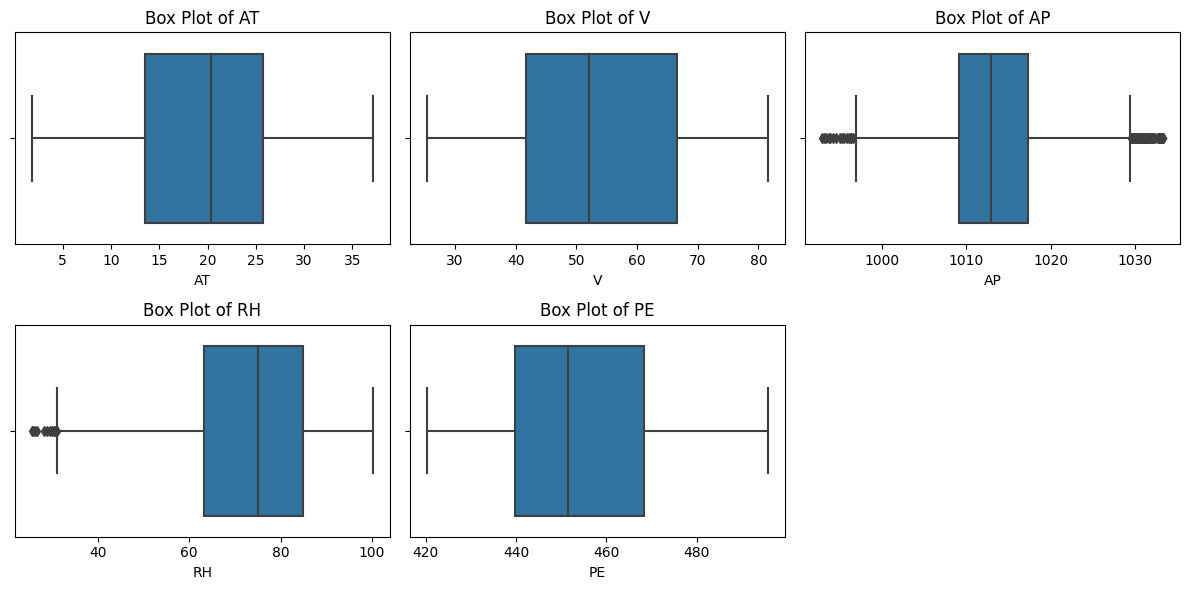

In [20]:
#Outlier analysis
print("Presence of any outliers in each numerical columns")
pt.figure(figsize=(12, 6))
for i, col in enumerate(dataset.columns):
    pt.subplot(2, 3, i + 1)
    sb.boxplot(x=dataset[col])
    pt.title(f'Box Plot of {col}')
pt.tight_layout()

folder_path7 = "E:\plots" 
file_name7 = "BLOXPLOT_plot.png"
pt.savefig(f"{folder_path7}/{file_name7}", dpi=300, bbox_inches='tight') 
pt.show()

As we can see, the outliers are mostly present in the columns like AP and RH, to improve feature scaling we need to remove the outliers

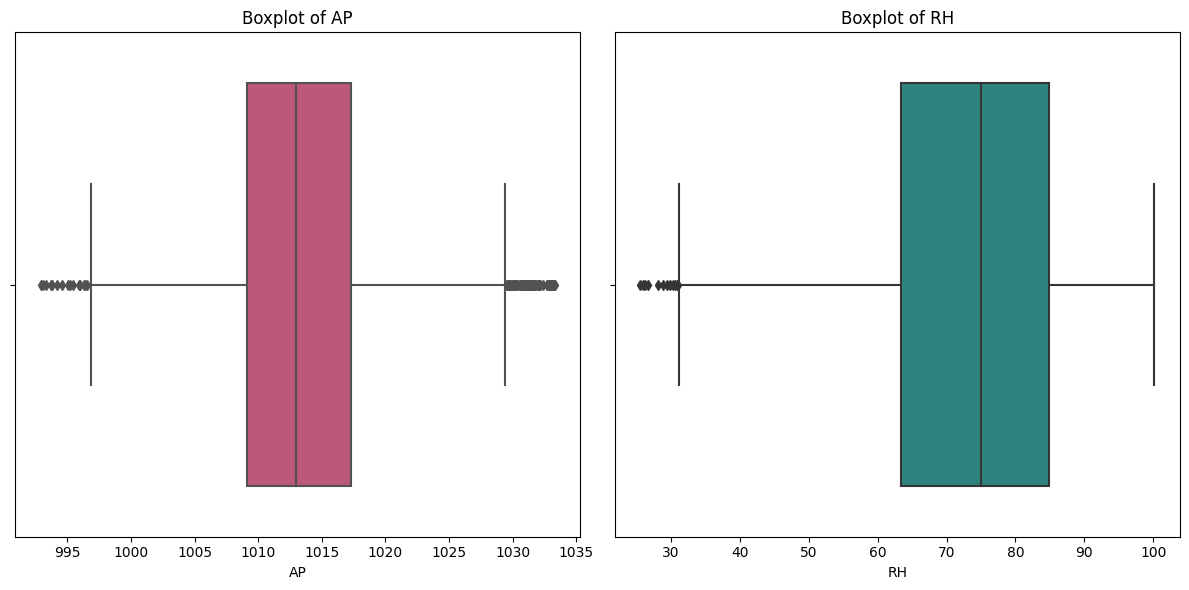

In [28]:
fig, axes = pt.subplots(1, 2, figsize=(12, 6))
sb.boxplot(data=dataset, x=dataset['AP'], ax=axes[0], palette="plasma") # Boxplot for AP
axes[0].set_title("Boxplot of AP")

sb.boxplot(data=dataset, x=dataset['RH'], ax=axes[1], palette="viridis") # Boxplot for RH
axes[1].set_title("Boxplot of RH")
pt.tight_layout()
pt.show()

#### Removing Outliers by Using IQR from AP and RH columns

The Interquartile Range (IQR) is a measure of statistical dispersion, or in simpler terms, it shows the spread of the middle 50% of the data. The formula to calculate IQR is:

**IQR = Q3-Q1**

Where:
- Q1 is the first quartile (25th percentile), which is the value below which 25% of the data fall.
- Q3 is the third quartile (75th percentile), which is the value below which 75% of the data fall.

Steps to calculate IQR:
 - Order the data in ascending order.
 - Find Q1 (the median of the lower half of the data).
 - Find Q3 (the median of the upper half of the data).
 - Subtract Q1 from Q3 to get the IQR.

The IQR helps in identifying outliers. Typically, any data point that is below 
Q1 − 1.5 × IQR or above Q3 + 1.5 × IQR is considered an outlier.

In [6]:
# Identifying Outliers in AP and RH columns
# Calculating  IQR for AP and RH
Q1ap = dataset['AP'].quantile(0.25)
Q3ap = dataset['AP'].quantile(0.75)
IQRap = Q3ap - Q1ap

Q1rh = dataset['RH'].quantile(0.25)
Q3rh = dataset['RH'].quantile(0.75)
IQRrh = Q3rh - Q1rh

#outlier thresholds
lower_bound_ap = Q1ap - 1.5 * IQRap
upper_bound_ap = Q3ap + 1.5 * IQRap

lower_bound_rh = Q1rh - 1.5 * IQRrh
upper_bound_rh = Q3rh + 1.5 * IQRrh

print(f"AP Outlier Range: {lower_bound_ap} to {upper_bound_ap}")
print(f"RH Outlier Range: {lower_bound_rh} to {upper_bound_rh}")

AP Outlier Range: 996.8600000000001 to 1029.5
RH Outlier Range: 31.073750000000004 to 117.08375


Filtering the rows where AP or RH values fall outside their respective bounds.

In [7]:
#removing outlier from AP
clean_dataset = dataset[
    (dataset['AP'] >= lower_bound_ap) & (dataset['AP'] <= upper_bound_ap)]

# Remove outliers from RH
clean_dataset = clean_dataset[
    (clean_dataset['RH'] >= lower_bound_rh) & (clean_dataset['RH'] <= upper_bound_rh)]

# Check the dataset after cleaning
print(f"Original data shape: {dataset.shape}")
print(f"Cleaned data shape: {clean_dataset.shape}")

Original data shape: (9568, 5)
Cleaned data shape: (9468, 5)


Visualizing before and after outliers from AP and RH COLUMNS

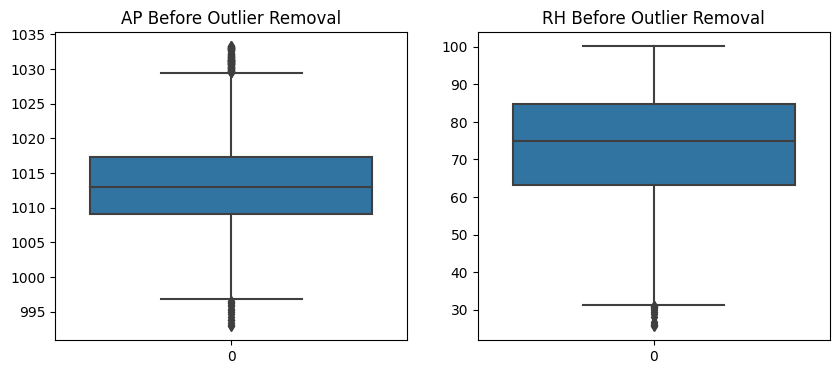

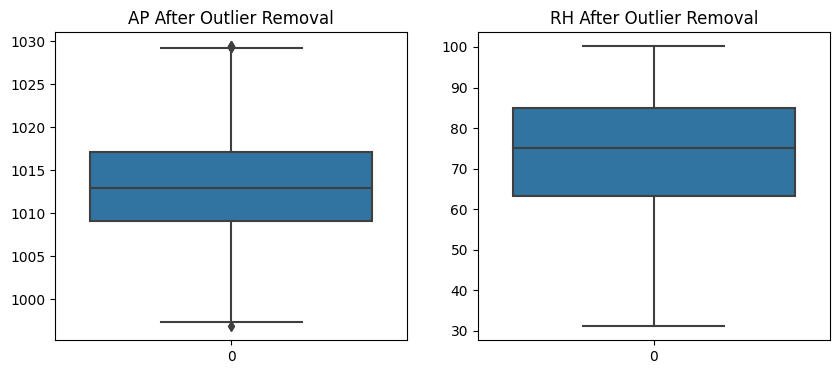

In [8]:
#before
pt.figure(figsize=(10, 4))
pt.subplot(1, 2, 1)
sb.boxplot(dataset['AP'])
pt.title('AP Before Outlier Removal')

pt.subplot(1, 2, 2)
sb.boxplot(dataset['RH'])
pt.title('RH Before Outlier Removal')
pt.show()

# After removing outliers
pt.figure(figsize=(10, 4))
pt.subplot(1, 2, 1)
sb.boxplot(clean_dataset['AP'])
pt.title('AP After Outlier Removal')

pt.subplot(1, 2, 2)
sb.boxplot(clean_dataset['RH'])
pt.title('RH After Outlier Removal')
pt.show()


As we can conclude that we sucessfully removed the outliers (not all, but 98% are removed) !

In [44]:
# print(clean_dataset[['AP', 'RH']].describe().T)

In [24]:
#Confirm that there are no values outside the defined thresholds
# print(clean_dataset[(clean_dataset['AP'] < lower_bound_ap) | (clean_dataset['AP'] > upper_bound_ap)])
# print(clean_dataset[(clean_dataset['RH'] < lower_bound_rh) | (clean_dataset['RH'] > upper_bound_rh)])

#### Renaming columns (Optional)

In [9]:
clean_dataset.rename(columns = {'AT':'Temperature', 'V':'Exhaust Vacuum', 'AP': 'Ambient Pressure',
                                      'RH':'Relative Humidity', 'PE':'Electrical energy output'}, inplace = True)
clean_dataset.head()

,Temperature,Exhaust Vacuum,Ambient Pressure,Relative Humidity,Electrical energy output
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


### Separating the features and the target into two different variables, X and y respectively.


In [10]:
#FEATURES
features = ['Temperature','Exhaust Vacuum', 'Ambient Pressure', 'Relative Humidity']
X = clean_dataset[features].values
print(X)

[[  14.96   41.76 1024.07   73.17]
 [  25.18   62.96 1020.04   59.08]
 [   5.11   39.4  1012.16   92.14]
 ...
 [  31.32   74.33 1012.92   36.48]
 [  24.48   69.45 1013.86   62.39]
 [  21.6    62.52 1017.23   67.87]]


In [11]:
#TARGET
y = clean_dataset['Electrical energy output'].values
print(y)

[463.26 444.37 488.56 ... 429.57 435.74 453.28]


It's crucial to evaluate a model's performance on unseen data to assess its generalization ability. This is where the train_test_split function from scikit-learn comes into play. 

**Training Set (X_train, y_train):**
- Used to train the machine learning model.
- The model learns patterns and relationships from this data.

**Test Set (X_test, y_test):**
 - Used to evaluate the model's performance on unseen data.
 - It helps assess how well the model generalizes to new, unseen examples.

In [12]:
# splitting the data 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [13]:
print(f"shape of X train: {X_train.shape} and shape of X test {X_test.shape}")

shape of X train: (7574, 4) and shape of X test (1894, 4)


In [14]:
print(f"shape of y train: {y_train.shape} and shape of y test {y_test.shape}")

shape of y train: (7574,) and shape of y test (1894,)


###  Feature Scaling: A Key Preprocessing Step (Optional in this situation)
 
***Common Feature Scaling Techniques:***

 - *Min-Max Scaling (Normalization):* Rescales features to a specific range, typically between 0 and 1.Formula: x_scaled = (x - min(x)) / (max(x) - min(x))

 - *Standardization (Z-score normalization):* Rescales features to have a mean of 0 and a standard deviation of 1. Formula: x_scaled = (x - mean(x)) / std(x)



In [53]:
#Feature scaling 
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()

# X_train = sc.fit_transform(X_train)
# X_test= sc.transform(X_test)

In [195]:
# print("Scaled X_train")
# print(X_train)

In [196]:
# print("Scaled X_test")
# print(X_test)

_________________________________________________ **THANK YOU** ________________________________________________________________